<a href="https://colab.research.google.com/github/KluyvertSouza/Estimacao-de-Volume-comercial-de-Madeira/blob/main/Modelagem_Volume_Comercial_de_Madeira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importação de dados ----

fonte = read.table("/content/geral(Dados).csv", encoding="UTF8", sep=";", quote="\"")
dados = fonte

## Tratamento dos dados ----
colnames(dados) = dados[1,] # Por problemas de importação, preferi ajustar o nome das colunas manualmente.
dados = dados[-1,]
names(dados)[c(2,4)] = c("Número arvore", "Nome Científico") # Problemas com acentos

library(stringr) #Para substituir ponto por vígula :)

dados$`DAP(m)` = str_replace(dados$`DAP(m)` , ',',  '.') %>% as.numeric()
dados$`Volume m3` = str_replace(dados$`Volume m3` , ',',  '.') %>% as.numeric()

# Problemas resolvidos :) (eu acho)
# ----------------------------------------------------- #


In [2]:
# Data Frame que contém dados referentes a todas as espécies.
head(dados)

,UMF_UPA,Número arvore,UT,Nome Científico,Nome Comum,DAP(m),Volume m3
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2,ALT4_UPA1,55,11,Brosimum parinarioides Ducke,Amapa doce,0.55,3.96
3,ALT4_UPA1,28,10,Neoxythece elegans (A.DC.) Aubret,Guajara pedra,0.70,6.47
4,ALT4_UPA1,44,10,Neoxythece elegans (A.DC.) Aubret,Guajara pedra,0.45,2.73
5,ALT4_UPA1,54,11,Neoxythece elegans (A.DC.) Aubret,Guajara pedra,0.89,11.35
6,ALT4_UPA1,64,11,Neoxythece elegans (A.DC.) Aubret,Guajara pedra,0.60,5.23
7,ALT4_UPA1,77,13,Neoxythece elegans (A.DC.) Aubret,Guajara pedra,0.60,5.03


In [4]:
# Vamos entender primeiro os dados
# Descritiva ----
library(dplyr)
especies = dados %>%
              group_by(`Nome Científico`) %>%
              count() %>%
              as.data.frame() %>%
              arrange(desc(n))

head(especies)

,Nome Científico,n
,<chr>,<int>
1,Tabebuia serratifolia,5007
2,Hymenaea courbaril,3902
3,Apuleia leiocarpa,3768
4,Tabebuia impetiginosa,1883
5,Couratari guianensis,831
6,Chrysophyllum lucentifolium,685


Como a espécie mais frequênte é a Tabebuia serratifolia, o exemplo mostrado será ela

In [5]:
grupos =
  dados %>%
  filter(`Nome Científico` == "Tabebuia serratifolia") %>%
  group_by(UMF_UPA) %>%
  count() %>%
  arrange(desc(n))

grupos

UMF_UPA,n
<chr>,<int>
ALT3_UPA2,1098
ALT4_UPA2,1041
ALT2_UPA2,766
ALT2_UPA1,676
ALT3_UPA1,626
ALT2_UPA3,308
ALT1_UPA1,290
ALT4_UPA1,202


O grupo mais frequente é o ALT3_UPA2, que se refere ao espaço cedido para manejo florestal, onde o dado foi coletado.
Os grupos causam diferença principalmente entre a idade das árvores, por tanto, não separar por grupo pode gerar heterocedasticidade dos resíduos.

Separado os dados, podemos fazer treinar diferentes modelos para predição, já que o propósito é avaliar qual modelo é mais apropriado.

| Modelo | Relação matemática (modelo de regressão) | Autores             |
|--------|--------------------------------|---------------------|
| 1      | $v = \beta_0 + \beta_1 d + \varepsilon_i$ | Berkhant            |
| 2      | $v = \beta_0 + \beta_1 d^2 + \varepsilon_i$ | Koperzky e Gehrhardt |
| 3      | $v = \beta_0 + \beta_1 d + \beta_2 d^2 + \varepsilon_i$ | Hohenadl e Krenn    |
| 4      | $\log v = \beta_0 + \beta_1 \log d + \beta_2 1/d + \varepsilon_i$ | Brenac              |
| 5      | $\log v = \beta_0 + \beta_1 \log d + \varepsilon_i$ | Husch|


Note que, para a criação de predição em si, nenhum pressuposto foi estabelecido.

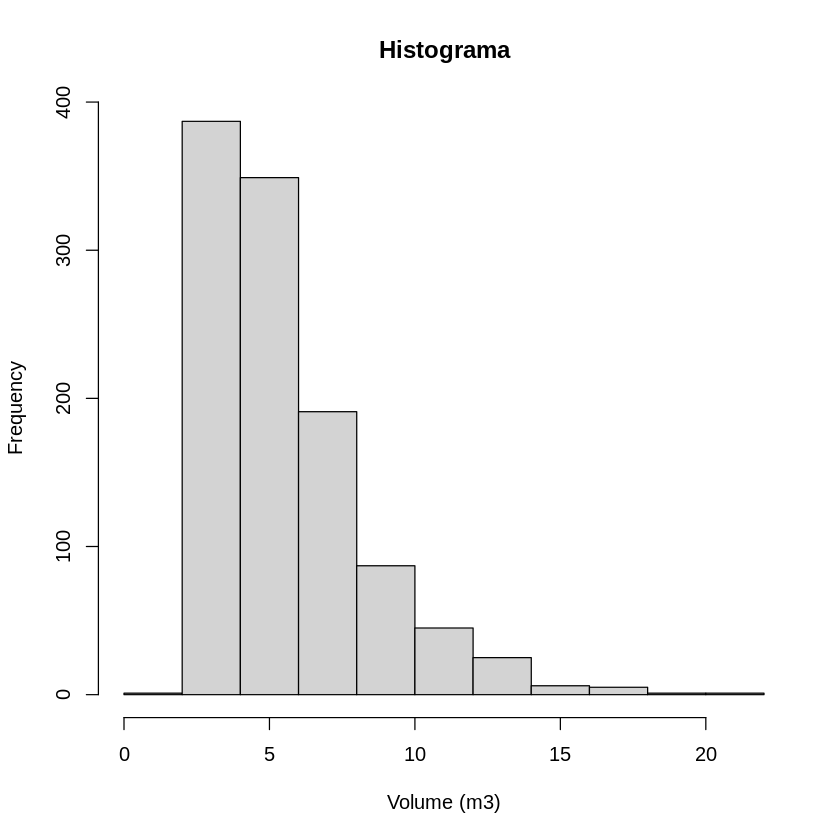

In [11]:
# Continuando a descritiva e filtrando os dados por espécie e local
filt_dados = dados |> filter(`Nome Científico` == "Tabebuia serratifolia" & UMF_UPA == "ALT3_UPA2")
hist(filt_dados$`Volume m3` , main = "Histograma" ,xlab = "Volume (m3)")

Podemos notar que os dados não têm distribuição normal. Apesar de ainda ser possível criar predições, e de fato faremos, não é possível fazer diagnósticos, criar intervalos de confiança e nem propor incerteza para nossas inferências. Na verdade, a rigor, a abordagem apropriada para esse caso seria recorrer aos modelos lineares generalizados. Isso será feito adiante

In [62]:
# Modelagem (normalidade não garantida)

pipe_models = function(dados,volume,dap){
modelos = list(md1 =lm(volume ~ dap , data = dados),
               md2 =lm(formula = volume ~ I(dap^2), data = dados),
               md3 =lm(volume ~ dap + I(dap^2), data = dados),
               md4 =lm(log(volume) ~ I(log(dap)) + I(dap^-1), data = dados ),
               md5 =lm(log(volume) ~ I(log(dap)), data = dados))
  names(modelos) = c("Berkhant" , "Koperzky e Gehrhardt","Hohenadl e Krenn", "Brenac", "Husch")
  return(modelos)
}


In [63]:
# Data splitting
#install.packages("rsample")
library(rsample)
set.seed(1005)
i = initial_split(filt_dados , prop = 0.7)
filt_dados_treino = training(i)
filt_dados_teste = testing(i)

In [64]:
# Matriz de dados e estimação

treino = data.frame("Volume_m3" = filt_dados_treino$`Volume m3` , "DAP" = filt_dados_treino$`DAP(m)`)
teste = data.frame("Volume_m3" = filt_dados_teste$`Volume m3` , "DAP" = filt_dados_teste$`DAP(m)`)
modelos = pipe_models(dados = treino, volume = treino$Volume_m3, dap = treino$DAP )

#Gosto de criar predições assim para não ter problemas com as transformações de variável

pred_1 = coef(modelos$Berkhant)[1] + coef(modelos$Berkhant)[2]*teste$DAP
pred_2 = coef(modelos$`Koperzky e Gehrhardt`)[1] + coef(modelos$`Koperzky e Gehrhardt`)[2]*(teste$DAP^2)
pred_3 = coef(modelos$`Hohenadl e Krenn`)[1] + coef(modelos$`Hohenadl e Krenn`)[2]*teste$DAP + coef(modelos$`Hohenadl e Krenn`)[3]*(teste$DAP^2)
pred_4 = coef(modelos$Brenac)[1] + coef(modelos$Brenac)[2]*log(teste$DAP) + coef(modelos$Brenac)[3]*(teste$DAP^-1)
pred_5 = coef(modelos$Husch)[1] + coef(modelos$Husch)[2]*log(teste$DAP)

#modelos$Berkhant
#modelos$`Koperzky e Gehrhardt`
#modelos$`Hohenadl e Krenn`
#modelos$Brenac
#modelos$Husch

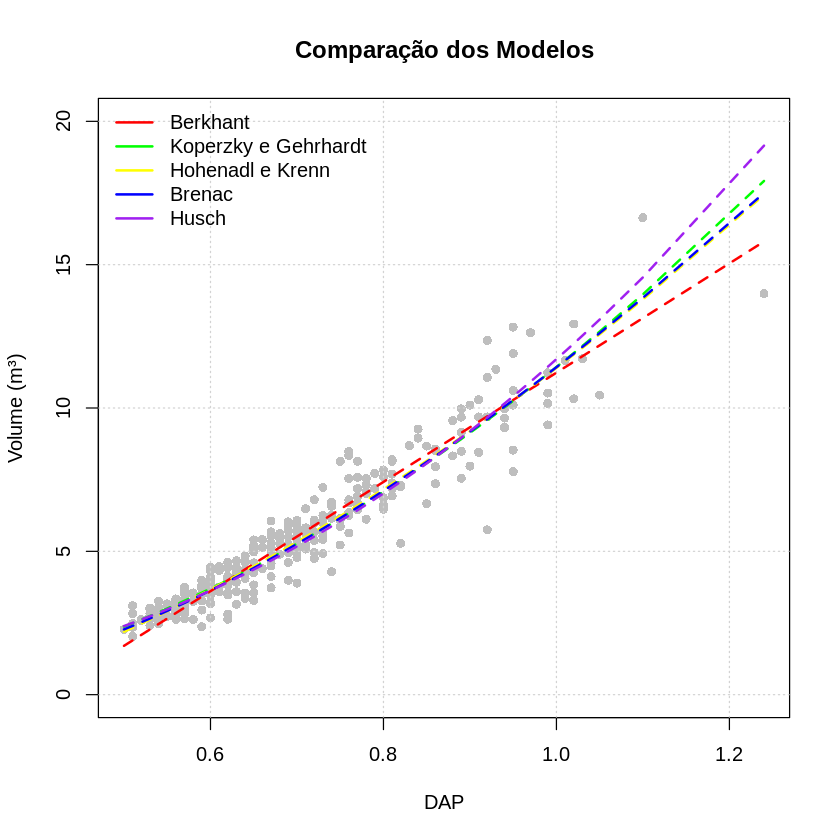

In [65]:
# 1. Ordena o DAP
ordem = order(teste$DAP)
dap_ordenado = teste$DAP[ordem]

# 2. Ordena também o Volume_m3 dos dados de teste (para o scatter ficar correto também, opcional)
volume_ordenado = teste$Volume_m3[ordem]

# 3. Recalcula as predições usando dap_ordenado
pred_1_ord = coef(modelos$Berkhant)[1] + coef(modelos$Berkhant)[2] * dap_ordenado
pred_2_ord = coef(modelos$`Koperzky e Gehrhardt`)[1] + coef(modelos$`Koperzky e Gehrhardt`)[2] * (dap_ordenado^2)
pred_3_ord = coef(modelos$`Hohenadl e Krenn`)[1] + coef(modelos$`Hohenadl e Krenn`)[2] * dap_ordenado + coef(modelos$`Hohenadl e Krenn`)[3] * (dap_ordenado^2)
pred_4_ord = coef(modelos$Brenac)[1] + coef(modelos$Brenac)[2] * log(dap_ordenado) + coef(modelos$Brenac)[3] * (dap_ordenado^-1)
pred_5_ord = coef(modelos$Husch)[1] + coef(modelos$Husch)[2] * log(dap_ordenado)

# 4. Faz o gráfico base (scatter plot dos dados reais)
plot(x = dap_ordenado, y = volume_ordenado, pch = 16, col = "gray", xlab = "DAP", ylab = "Volume (m³)",
     main = "Comparação dos Modelos" , ylim = c(0,20) , xlim = c(min(dap_ordenado),max(dap_ordenado)))
grid()
# Linhas tracejadas e coloridas
lines(x = dap_ordenado, y = pred_1_ord, col = "red", lwd = 2, lty = 2)
lines(x = dap_ordenado, y = pred_2_ord, col = "green", lwd = 2, lty = 2)
lines(x = dap_ordenado, y = pred_3_ord, col = "yellow", lwd = 2, lty = 2)
lines(x = dap_ordenado, y = exp(pred_4_ord), col = "blue", lwd = 2, lty = 2)
lines(x = dap_ordenado, y = exp(pred_5_ord), col = "purple", lwd = 2, lty = 2)

# 6. Adiciona legenda
legend("topleft", legend = c("Berkhant", "Koperzky e Gehrhardt", "Hohenadl e Krenn", "Brenac", "Husch"),
       col = c("red", "green", "yellow", "blue", "purple"), lty = 1, lwd = 2, bty = "n")


In [66]:
AICS = lapply(modelos , AIC)

table_models = NULL

table_models$modelos = c("Berkhant" , "Koperzky e Gehrhardt","Hohenadl e Krenn", "Brenac", "Husch")
table_models$EQM = c(sum((teste$Volume_m3 - pred_1)^2),
sum((teste$Volume_m3 - pred_2)^2),
sum((teste$Volume_m3 - pred_3)^2),
sum((teste$Volume_m3 - exp(pred_4))^2),
sum((teste$Volume_m3 - exp(pred_5))^2))
for(m in 1:5) {table_models$AIC[m] = AICS[[m]]}

table_models |> as.data.frame() |> arrange(EQM)


modelos,EQM,AIC
<chr>,<dbl>,<dbl>
Hohenadl e Krenn,187.5902,1503.826
Berkhant,187.7729,1628.998
Brenac,190.9490,-1127.964
Koperzky e Gehrhardt,194.0501,1516.512
Husch,212.5236,-1109.151


O melhor modelo então, é o que apresentar menor erro quadrático médio (EQM)